# Team Name: MISO Regression

* Team Members: 김민경(Team Leader), 장승현, 신승훈 
* Objective: 중고차 가격 예측 모델 구현
* Target Objective: R^2 > 80% 이상이면 더 general 한 Model 선택

# 분석 순서

* EDA
* Outlier 처리 & Data Cleaning
* 단순 회귀분석 진행 --> 변수 선택에 대한 가설 수립
* 신규 변수 생성
* 단순 회귀분석 진행2
* 다중 회귀분석 진행
* 최종 변수 선택
* 예측 및 평가 

# 시작하기 전에......다음 기수부터는 실수하지 마세요~혹은 의도적??

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('C:\\Users\\ACEIT\\Documents\\DSS\\Project\\Usedcar\\train.csv')

In [3]:
post_data = data.copy()
post_data = pd.DataFrame(post_data)

# EDA
* EDA는 기본적으로 박재근 Manager가 Slack을 통해 공유한 내용을 똑같이 실행하는 방식으로 진행
* EDA 부분은 다른 조와 비슷할 것으로 판단되어 발표에서는 Skip하도록 함

# Outlier처리 & Data Cleaning

#### 오타로 생각되는 비현실적인 CC들을 가장 근사한 100단위 CC로 변경

In [4]:
post_data['CC'].replace(1598, 1600, inplace=True)
post_data['CC'].replace(1587, 1600, inplace=True)
post_data['CC'].replace(1995, 1900, inplace=True)
post_data['CC'].replace(16000, 1600, inplace=True)
post_data['CC'].replace(1398, 1400, inplace=True)
post_data['CC'].replace(1332, 1300, inplace=True)

In [5]:
print data['CC'].value_counts()
print post_data['CC'].value_counts()

1600     608
1300     177
1400     114
2000      81
1900      22
1800       9
1598       2
1587       2
1995       1
16000      1
1398       1
1332       1
Name: CC, dtype: int64
1600    613
1300    178
1400    115
2000     81
1900     23
1800      9
Name: CC, dtype: int64


#### KM에 1, 15 역시 오타로 판단하여 당해년도 평균 값으로 변경
##### 물론 중고차라도 Km가 15km 미만일 수는 있다. 그러나,
      1. 출시 후 2년 이상이 지난 차임에도 불구하고 km가 낮았다는 점
      2. Km가 1로 거의 새 차임에도 불구하고 가격 차이가 평균 km 차들과 차이가 없었다는 점

In [6]:
post_data[post_data['KM']==1][post_data['Mfg_Year']==1998].index
post_data[post_data['KM']==1][post_data['Mfg_Year']==2003].index
post_data[post_data['KM']==1][post_data['Mfg_Year']==2004].index
post_data[post_data['KM']==15][post_data['Mfg_Year']==2004].index

post_data['KM'][post_data['Mfg_Year']==1998].median()
post_data['KM'][post_data['Mfg_Year']==2003].median()
post_data['KM'][post_data['Mfg_Year']==2004].median()

post_data['KM'][1018] = 82635.0
post_data['KM'][125] = 22881.5
post_data['KM'][83] = 8574.0
post_data['KM'][133] = 8574.0
post_data['KM'][132] = 8574.0



C:\Python27\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Python27\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Python27\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Python27\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Python27\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.pat

#### 또한 CC를 잘못 적은 경우가 있을 수 있어 모델에 나와있는 배기량 정보와 CC 컬럼과 비교하여 수정하였다

In [7]:
post_data.iloc[[63, 96, 101, 145, 336, 342, 445, 589, 678], post_data.columns.get_indexer(['Price','Model','engine','CC', 'Mfg_Year'])]
post_data['CC'][63] = 2000
post_data['CC'][336] = 1900
post_data['CC'][342] = 1400
post_data['CC'][342]

C:\Python27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Python27\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Python27\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


1400

In [8]:
y_data = post_data['Price']
cols_nu = ['Age_08_04', 'Mfg_Year', 'KM', 'HP', 'CC', 'Quarterly_Tax', 'Weight','Guarantee_Period']
cols_cat = ['Model','Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee',
            'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
            'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
            'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']
x_nu = post_data[cols_nu]
x_cat = post_data[cols_cat]

# 단순회귀분석 진행

In [9]:
nu_variable_stats = pd.DataFrame(index = cols_nu, columns = ['R2', 'P-value', 'Beta'])
cat_variable_stats = pd.DataFrame(index = cols_cat, columns = ['R2', 'P-value', 'Beta'])

In [10]:
for i in cols_nu:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    nu_variable_stats.loc[i, 'R2'] = model.rsquared
    nu_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    nu_variable_stats.loc[i, 'Beta'] = model.params[1]
nu_variable_stats.sort_values('R2', ascending=False)

,R2,P-value,Beta
Mfg_Year,0.797988,0,2085.3
Age_08_04,0.781279,0,-171.649
KM,0.333567,1.03693e-91,-0.0551872
Weight,0.310266,4.1794e-84,39.2081
HP,0.0991609,6.8285e-25,76.8569
Quarterly_Tax,0.0319958,8.95663e-09,16.4635
Guarantee_Period,0.0276028,9.60109e-08,205.276
CC,0.0210399,3.33192e-06,2.83832


In [11]:
for i in cols_cat:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    cat_variable_stats.loc[i, 'R2'] = model.rsquared
    cat_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    cat_variable_stats.loc[i, 'Beta'] = model.params[1]

cat_variable_stats.sort_values('R2', ascending=False)[:5]

,R2,P-value,Beta
Model,0.916366,3.84556e-261,550
Boardcomputer,0.365576,1.3363e-102,4846.7
Automatic_airco,0.354131,1.20611e-98,9063.62
CD_Player,0.243082,1.58629e-63,4254.76
Airco,0.197411,1.52604e-50,3210.9


#### 그런데 Category 변수의 경우 너무 비율이 안 맞는 경우도 있으며, 어떤 값들로 구성되어 있는지 알기가 어렵다

In [12]:
for i in cols_cat[1:]: 
    temp_dict = dict(x_cat[i].value_counts())
    total = sum(temp_dict.values())
    for key in temp_dict.keys():
        cat_variable_stats.loc[i, key] = temp_dict[key] / float(total) * 100
for i in cols_cat:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    cat_variable_stats.loc[i, 'R2'] = model.rsquared
    cat_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    cat_variable_stats.loc[i, 'Beta'] = model.params[1]

cat_variable_stats.sort_values('R2', ascending=False)[:5]

,R2,P-value,Beta,Petrol,CNG,Diesel,0,1,Blue,Grey,...,Violet,Green,White,Silver,Red,2,3,4,5,6
Model,0.916366,3.84556e-261,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boardcomputer,0.365576,1.3363e-102,4846.7,NaN,NaN,NaN,71.638862,28.361138,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Automatic_airco,0.354131,1.20611e-98,9063.62,NaN,NaN,NaN,94.013739,5.986261,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_Player,0.243082,1.58629e-63,4254.76,NaN,NaN,NaN,77.330716,22.669284,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Airco,0.197411,1.52604e-50,3210.9,NaN,NaN,NaN,49.558391,50.441609,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 신규변수 생성

## EDA적 접근

#### 일단, 아무리 봐도 2002년부터 갑자기 가격이 오르는 모습이 보인다. 
#### Mfg_Year를 2개의 Category 변수로 바꿔보자

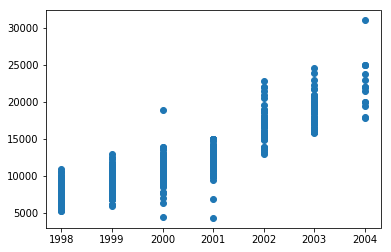

In [13]:
plt.scatter(post_data['Mfg_Year'], post_data['Price'])
plt.show()

In [14]:
post_data['After_2002'] = post_data.apply(lambda x: x['Mfg_Year'] < 2002, axis = 1)
dummy = pd.get_dummies(post_data['After_2002'], drop_first=True)
dummy.columns = ['After_2002']
post_data['After_2002'] = dummy['After_2002']
post_data['After_2002'].value_counts()

1    885
0    134
Name: After_2002, dtype: int64

#### 모델을 살펴보니 VVT 라고 쓰여 있는 모델들이 평균 가격이 더 높다
#### VVT인 모델과 아닌 모델로 구분해보자

In [15]:
#post_data.groupby('Model', as_index=True)['Price'].mean()[:3]

In [16]:
import re
pattern = re.compile(r'vvt', flags=re.IGNORECASE)
vvt= []
for i in post_data['Model']:
    result = pattern.search(i)
    if result:
        vvt.append(1)
    else:
        vvt.append(0)

post_data['vvt'] = pd.Series(vvt)
post_data[:2]

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar,After_2002,vvt
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,0,0,0,1,0,0,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,0,0,1,0,0,0,0,0,0


## 휴리스틱적 접근

#### 자동차를 살 때 보통 여러 Option들이 묶여서 세부 Model Line에 적용되지 않는가?
#### R^2가 10% ~ 30%인 옵션들은 묶어서 연속형 변수로 만들어보자
##### (단, 각 변수들의 단수 회귀분석에서의 R^2값, 그리고 이후 다중 회귀분석의 시뮬레이션 값을 토대로 가중치를 정했다)

In [17]:
post_data['Premium_option'] = (post_data['CD_Player']*2)+(post_data['Airco']*1.2)+post_data['Powered_Windows']+post_data['Central_Lock']+post_data['ABS']

#### 자동차를 살 때를 생각해보자
#### 우리는 먼저 "몇년도 모델인지"를 물어볼 것이다. 
#### 그런 다음 같은 년도 모델에 비슷한 사양이라면, Km수가 더 낮은 차량을 선택할 것이다.
#### 따라서 Km 변수를 그대로 두면 다중공선성 Risk를 갖게 되지만 각각의 해당년도 Km끼리만을 비교해 준다면 의미가 있을 것이다

In [20]:
post_data['KM_from_mean'] = ''
kmmean_1998 = post_data['KM'][post_data['Mfg_Year']==1998].mean()
kmstd_1998 = post_data['KM'][post_data['Mfg_Year']==1998].std()

kmmean_1999 = post_data['KM'][post_data['Mfg_Year']==1999].mean()
kmstd_1999 = post_data['KM'][post_data['Mfg_Year']==1999].std()

kmmean_2000 = post_data['KM'][post_data['Mfg_Year']==2000].mean()
kmstd_2000 = post_data['KM'][post_data['Mfg_Year']==2000].std()

kmmean_2001 = post_data['KM'][post_data['Mfg_Year']==2001].mean()
kmstd_2001 = post_data['KM'][post_data['Mfg_Year']==2001].std()

kmmean_2002 = post_data['KM'][post_data['Mfg_Year']==2002].mean()
kmstd_2002 = post_data['KM'][post_data['Mfg_Year']==2002].std()

kmmean_2003 = post_data['KM'][post_data['Mfg_Year']==2003].mean()
kmstd_2003 = post_data['KM'][post_data['Mfg_Year']==2003].std()

kmmean_2004 = post_data['KM'][post_data['Mfg_Year']==2004].mean()
kmstd_2004 = post_data['KM'][post_data['Mfg_Year']==2004].std()

temp_list = []
for i in range(len(post_data['Mfg_Year'])):
    if post_data.loc[i,'Mfg_Year'] == 1998:
        temp_list.append((kmmean_1998 - post_data.loc[i, 'KM'])/kmstd_1998)
    elif post_data.loc[i,'Mfg_Year'] == 1999:
        temp_list.append((kmmean_1999 - post_data.loc[i, 'KM'])/kmstd_1999)
    elif post_data.loc[i,'Mfg_Year'] == 2000:
        temp_list.append((kmmean_2000 - post_data.loc[i, 'KM'])/kmstd_2000)
    elif post_data.loc[i,'Mfg_Year'] == 2001:
        temp_list.append((kmmean_2001 - post_data.loc[i, 'KM'])/kmstd_2001)
    elif post_data.loc[i,'Mfg_Year'] == 2002:
        temp_list.append((kmmean_2002 - post_data.loc[i, 'KM'])/kmstd_2002)
    elif post_data.loc[i,'Mfg_Year'] == 2003:
        temp_list.append((kmmean_2003 - post_data.loc[i, 'KM'])/kmstd_2003)
    elif post_data.loc[i,'Mfg_Year'] == 2004:
        temp_list.append((kmmean_2004 - post_data.loc[i, 'KM'])/kmstd_2004)
    else:
        print "There's a motherfucker at{}".format(i)

post_data['KM_from_mean_std_base'] = temp_list  

In [21]:
post_data['KM_from_mean'] = ''
kmmean_1998 = post_data['KM'][post_data['Mfg_Year']==1998].mean()
kmstd_1998 = post_data['KM'][post_data['Mfg_Year']==1998].std()

kmmean_1999 = post_data['KM'][post_data['Mfg_Year']==1999].mean()
kmstd_1999 = post_data['KM'][post_data['Mfg_Year']==1999].std()

kmmean_2000 = post_data['KM'][post_data['Mfg_Year']==2000].mean()
kmstd_2000 = post_data['KM'][post_data['Mfg_Year']==2000].std()

kmmean_2001 = post_data['KM'][post_data['Mfg_Year']==2001].mean()
kmstd_2001 = post_data['KM'][post_data['Mfg_Year']==2001].std()

kmmean_2002 = post_data['KM'][post_data['Mfg_Year']==2002].mean()
kmstd_2002 = post_data['KM'][post_data['Mfg_Year']==2002].std()

kmmean_2003 = post_data['KM'][post_data['Mfg_Year']==2003].mean()
kmstd_2003 = post_data['KM'][post_data['Mfg_Year']==2003].std()

kmmean_2004 = post_data['KM'][post_data['Mfg_Year']==2004].mean()
kmstd_2004 = post_data['KM'][post_data['Mfg_Year']==2004].std()

temp_list = []
for i in range(len(post_data['Mfg_Year'])):
    if post_data.loc[i,'Mfg_Year'] == 1998:
        temp_list.append((kmmean_1998 - post_data.loc[i, 'KM'])/kmmean_1998)
    elif post_data.loc[i,'Mfg_Year'] == 1999:
        temp_list.append((kmmean_1999 - post_data.loc[i, 'KM'])/kmmean_1999)
    elif post_data.loc[i,'Mfg_Year'] == 2000:
        temp_list.append((kmmean_2000 - post_data.loc[i, 'KM'])/kmmean_2000)
    elif post_data.loc[i,'Mfg_Year'] == 2001:
        temp_list.append((kmmean_2001 - post_data.loc[i, 'KM'])/kmmean_2001)
    elif post_data.loc[i,'Mfg_Year'] == 2002:
        temp_list.append((kmmean_2002 - post_data.loc[i, 'KM'])/kmmean_2002)
    elif post_data.loc[i,'Mfg_Year'] == 2003:
        temp_list.append((kmmean_2003 - post_data.loc[i, 'KM'])/kmmean_2003)
    elif post_data.loc[i,'Mfg_Year'] == 2004:
        temp_list.append((kmmean_2004 - post_data.loc[i, 'KM'])/kmmean_2004)
    else:
        print "There's a motherfucker at{}".format(i)

post_data['KM_from_mean_mean_base'] = temp_list


In [22]:
temp_list = []
for i in range(len(post_data['Mfg_Year'])):
    if post_data.loc[i,'Mfg_Year'] == 1998:
        temp_list.append((kmmean_1998 - post_data.loc[i, 'KM']))
    elif post_data.loc[i,'Mfg_Year'] == 1999:
        temp_list.append((kmmean_1999 - post_data.loc[i, 'KM']))
    elif post_data.loc[i,'Mfg_Year'] == 2000:
        temp_list.append((kmmean_2000 - post_data.loc[i, 'KM']))
    elif post_data.loc[i,'Mfg_Year'] == 2001:
        temp_list.append((kmmean_2001 - post_data.loc[i, 'KM']))
    elif post_data.loc[i,'Mfg_Year'] == 2002:
        temp_list.append((kmmean_2002 - post_data.loc[i, 'KM']))
    elif post_data.loc[i,'Mfg_Year'] == 2003:
        temp_list.append((kmmean_2003 - post_data.loc[i, 'KM']))
    elif post_data.loc[i,'Mfg_Year'] == 2004:
        temp_list.append((kmmean_2004 - post_data.loc[i, 'KM']))
    else:
        print "There's a motherfucker at{}".format(i)

post_data['KM_from_mean'] = temp_list


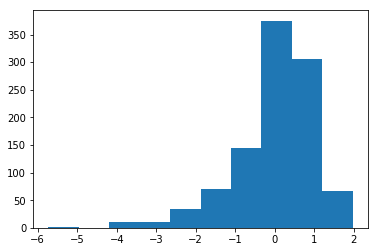

In [23]:
plt.hist(post_data['KM_from_mean_std_base'])
plt.show()

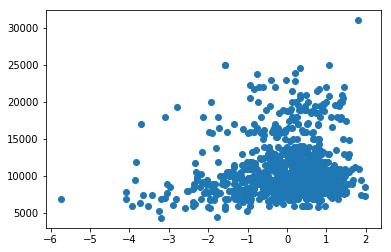

In [24]:
plt.scatter(post_data['KM_from_mean_std_base'], post_data['Price'])
plt.show()

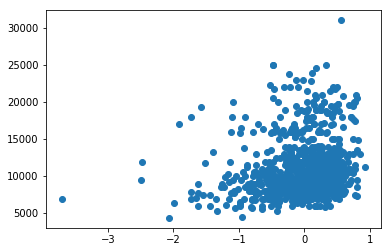

In [25]:
plt.scatter(post_data['KM_from_mean_mean_base'], post_data['Price'])
plt.show()

### 이후 살펴볼 필요가 있다고 생각되는 몇 개의 Category 변수들에 대해서는 Dummification 진행

In [26]:
dummy = pd.get_dummies(post_data['Doors'], drop_first=True)
dummy.columns = ['D3','D4', 'D5']
dummy[:3]
post_data = pd.concat([post_data, dummy], axis = 1)
dummy = pd.get_dummies(post_data['Fuel_Type'], drop_first=True)
dummy.columns = ['Diesel','Petrol']
dummy[:3]
post_data = pd.concat([post_data, dummy], axis = 1)

### 추가된 변수들을 Column List에도 추가

In [27]:
y_data = post_data['Price']
cols_nu = ['Age_08_04', 'Mfg_Year', 'KM', 'HP', 'CC', 'Quarterly_Tax', 'Weight','Guarantee_Period', 'Premium_option', 
           'KM_from_mean_std_base','KM_from_mean_mean_base', 'KM_from_mean']
cols_cat = ['Model', 'Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee',
            'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
            'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
            'Radio_cassette', 'Parking_Assistant', 'Tow_Bar','After_2002', 'vvt', 'D3', 'D4', 'D5', 'Diesel', 'Petrol']

### 변수 생성을 정리하면?
* 가격(평균, Minimum, Median)이 급격한 변화를 보이는 2002년을 기점으로 모델을 구분할 수 있는 Category 변수 생성
* VVT라는 이름이 들어가는 변수들을 Category 변수 생성
* 고가격, 높은 R^2의 옵션들을 Premium Option이라는 연속형 변수로 수정
* Km를 각 년도의 평균을 중심으로 하여 -, + 로 나타타는 수치로 표준화

### 이제 단순 회귀분석을 다시 돌려보자

In [28]:
for i in cols_nu:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    nu_variable_stats.loc[i, 'R2'] = model.rsquared
    nu_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    nu_variable_stats.loc[i, 'Beta'] = model.params[1]
nu_variable_stats.sort_values('R2', ascending=False)

,R2,P-value,Beta
Mfg_Year,0.797988,0,2085.3
Age_08_04,0.781279,0,-171.649
Premium_option,0.356501,1.85348e-99,1114.52
KM,0.333567,1.03693e-91,-0.0551872
Weight,0.310266,4.1794e-84,39.2081
HP,0.0991609,6.8285e-25,76.8569
Quarterly_Tax,0.0319958,8.95663e-09,16.4635
Guarantee_Period,0.0276028,9.60109e-08,205.276
CC,0.0210399,3.33192e-06,2.83832
KM_from_mean_mean_base,0.0184914,1.32616e-05,1015.75


In [29]:
for i in cols_cat[1:]: 
    temp_dict = dict(post_data[i].value_counts())
    total = sum(temp_dict.values())
    for key in temp_dict.keys():
        cat_variable_stats.loc[i, key] = temp_dict[key] / float(total) * 100

for i in cols_cat:
    model = smf.ols("Price ~ {}".format(i), post_data).fit()
    cat_variable_stats.loc[i, 'R2'] = model.rsquared
    cat_variable_stats.loc[i, 'P-value'] = model.f_pvalue
    cat_variable_stats.loc[i, 'Beta'] = model.params[1]


cat_variable_stats.sort_values('R2', ascending=False)

,R2,P-value,Beta,Petrol,CNG,Diesel,0,1,Blue,Grey,...,Violet,Green,White,Silver,Red,2,3,4,5,6
Model,0.916366,3.84556e-261,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
After_2002,0.664398,2.33686e-243,-8714.81,NaN,NaN,NaN,13.150147,86.849853,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boardcomputer,0.365576,1.3363e-102,4846.7,NaN,NaN,NaN,71.638862,28.361138,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Automatic_airco,0.354131,1.20611e-98,9063.62,NaN,NaN,NaN,94.013739,5.986261,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vvt,0.350618,1.91189e-97,4557.91,NaN,NaN,NaN,67.222767,32.777233,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CD_Player,0.243082,1.58629e-63,4254.76,NaN,NaN,NaN,77.330716,22.669284,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Airco,0.197411,1.52604e-50,3210.9,NaN,NaN,NaN,49.558391,50.441609,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Powered_Windows,0.131775,4.26527e-33,2647.29,NaN,NaN,NaN,43.277723,56.722277,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Central_Lock,0.13047,9.19823e-33,2649.6,NaN,NaN,NaN,41.413150,58.586850,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABS,0.0926474,2.753e-23,2823.78,NaN,NaN,NaN,18.645731,81.354269,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 다중회귀분석 진행

In [63]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [64]:
train_component = ['Age_08_04', 'KM', 'Premium_option', 'Weight', 'HP',
                              'Boardcomputer','Automatic_airco', 'vvt', 'After_2002']
train_variable= post_data[train_component]



In [65]:
model = LinearRegression()
score = cross_val_score(model, train_variable, y_data, cv = KFold(n_splits=10, shuffle=True))
print score
print score.mean()

[ 0.90089296  0.89625522  0.8878591   0.86392588  0.86578686  0.90140925
  0.9036284   0.89991419  0.89972782  0.91069292]
0.89300926184


In [66]:
model_ols = smf.ols("Price ~ Age_08_04 + KM + Premium_option + Weight + HP + Boardcomputer + Automatic_airco + vvt", post_data).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     978.5
Date:                Fri, 30 Jun 2017   Prob (F-statistic):               0.00
Time:                        13:05:26   Log-Likelihood:                -8688.8
No. Observations:                1019   AIC:                         1.740e+04
Df Residuals:                    1010   BIC:                         1.744e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1395.7948   1172.019      1.191      0.234    -904.076    3695.665
Age_08_04        -113.8314      4.328    -26.298      0.000    -122.325    -105.338
KM                 -0.0180      0.001    -13.490      0.000      -0.021      -0.015
Premium_option    152.6295     25.854      5.904      0.000     101.896     203.363
Weight             13.4573      0.990     13.591      0.000      11.514      15.400
HP                 19.5693      3.034      6.449      0.000      13.615      25.524
Boardcomputer    -276.4633    145.611     -1.899      0.058    -562.197       9.271
Automatic_airco  2529.2727    192.036     13.171      0.000    2152.437    2906.108
vvt                 3.3316    150.975      0.022      0.982    -292.929     299.592
==============================================================================
Omnibus:                       79.258   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.296
Skew:                          -0.075   Prob(JB):                     5.35e-87
Kurtosis:                       6.055   Cond. No.                     2.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Test Set에 Prediction 값 기입

In [67]:
test_data = pd.read_csv('C:\\Users\\ACEIT\\Documents\\DSS\\Project\\Usedcar\\test.csv')

In [68]:
test_data['After_2002'] = test_data.apply(lambda x: x['Mfg_Year'] < 2002, axis = 1)

In [69]:
dummy = pd.get_dummies(test_data['After_2002'], drop_first=True)
dummy.columns = ['After_2002']
test_data['After_2002'] = dummy['After_2002']
test_data['After_2002'].value_counts()

1    365
0     52
Name: After_2002, dtype: int64

In [70]:
import re
pattern = re.compile(r'vvt', flags=re.IGNORECASE)
vvt= []
for i in test_data['Model']:
    result = pattern.search(i)
    if result:
        vvt.append(1)
    else:
        vvt.append(0)

test_data['vvt'] = pd.Series(vvt)

In [71]:
test_data['Premium_option'] = (test_data['CD_Player']*2)+(test_data['Airco']*1.2)+test_data['Powered_Windows']+test_data['Central_Lock']+test_data['ABS']

#### 낮은 r^2값으로 Model에서 제외 되었었던 변수들을 굳이 Test Set에 넣지 않았다

In [72]:
test_data['Predicted'] =''
y_hat_data = test_data['Predicted']
test_cols_nu = ['Age_08_04', 'Mfg_Year', 'KM', 'HP', 'CC', 'Quarterly_Tax', 'Weight','Guarantee_Period', 'Premium_option']
test_cols_cat = ['Model', 'Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee',
            'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
            'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
            'Radio_cassette', 'Parking_Assistant', 'Tow_Bar','After_2002', 'vvt']

In [73]:
test_data[:2]

,Id,Model,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,...,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar,After_2002,vvt,Premium_option,Predicted
0,3,��TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,24,9,2002,41711,Diesel,90,1,Blue,...,0,1,0,0,0,0,0,0,1.0,
1,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,26,7,2002,48000,Diesel,90,0,Black,...,0,1,0,0,0,0,0,0,1.0,


In [74]:
model.fit(post_data[train_component],
          post_data[['Price']])
test_data['Predicted'] = model.predict(test_data[train_component])

In [75]:
test_data.to_csv('C:\\Users\\ACEIT\\Documents\\DSS\\Project\\Usedcar\\test_MISOregression_final.csv')

# 재미있는 실험을 해보자

In [76]:
all_set = pd.read_excel('C:\\Users\\ACEIT\\Documents\\DSS\\Project\\Usedcar\\explanation-of-features.xls', sheetname='data')

In [77]:
gap = pd.DataFrame()
gap['Id'] = test_data['Id']
gap['Predicted'] = test_data['Predicted']
gettheprice = []
for i in gap['Id']:
    gettheprice.append(int(all_set['Price'][all_set['Id']==i]))
print gettheprice[5]

21500


In [78]:
gap['realprice'] = gettheprice
gap['sse'] = (gap.Predicted - gap.realprice)**2
avg_realprice = gap['realprice'].mean()
gap['ssr'] = (gap.Predicted - avg_realprice)**2

In [79]:
model_rsqare = gap['ssr'].sum() / (gap['sse'].sum() + gap['ssr'].sum())
print model_rsqare
print gap['sse'].mean()

0.887517947117
1418190.10166


## 우리는 이미 최종 Score가 위의 숫자가 될 것을 알고 있다

In [80]:
model_after2002 = LinearRegression()
model_after2002.fit(post_data[['Age_08_04', 'KM', 'Boardcomputer','Automatic_airco', 
                      'Weight', 'vvt', 'Premium_option']][post_data['After_2002']==1],post_data['Price'][post_data['After_2002'] == 1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
model_before2002 = LinearRegression()
model_before2002.fit(post_data[['Age_08_04', 'KM', 'Boardcomputer','Automatic_airco', 
                      'Weight', 'vvt', 'Premium_option', 'CC']][post_data['After_2002']==0],post_data['Price'][post_data['After_2002'] == 0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [82]:
test_data['Predicted'] = 0

In [83]:
test_data['Predicted'][test_data['After_2002'] == 1] = model_after2002.predict(test_data[['Age_08_04', 'KM', 'Boardcomputer','Automatic_airco',
                                               'Weight', 'vvt', 'Premium_option']][test_data['After_2002']==1])

C:\Python27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
test_data['Predicted'][test_data['After_2002'] == 0] = model_before2002.predict(test_data[['Age_08_04', 'KM', 'Boardcomputer','Automatic_airco',
                                               'Weight', 'vvt', 'Premium_option','CC']][test_data['After_2002']==0])

C:\Python27\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [85]:
print test_data['After_2002'].value_counts()

1    365
0     52
Name: After_2002, dtype: int64


In [86]:
gap = pd.DataFrame()
gap['Id'] = test_data['Id']
gap['Predicted'] = test_data['Predicted']
gettheprice = []
for i in gap['Id']:
    gettheprice.append(int(all_set['Price'][all_set['Id']==i]))
    
gap['realprice'] = gettheprice
gap['sse'] = (gap.Predicted - gap.realprice)**2
avg_realprice = gap['realprice'].mean()
gap['ssr'] = (gap.Predicted - avg_realprice)**2

model_rsqare = gap['ssr'].sum() / (gap['sse'].sum() + gap['ssr'].sum())
print model_rsqare
print gap['sse'].mean()

0.905982337098
1209570.41073
